# Operational Load Hotspots

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 150          # display resolution
plt.rcParams["savefig.dpi"] = 300         # saved image quality

## Load Datasets

In [3]:
ENROL1_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv'
ENROL2_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv'
ENROL3_PATH = 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv'

DEMO1_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv'
DEMO2_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv'
DEMO3_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv'
DEMO4_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv'
DEMO5_PATH = 'api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv'

BIO1_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv'
BIO2_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv'
BIO3_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv'
BIO4_PATH = 'api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv'

In [4]:
enrol1= pd.read_csv(ENROL1_PATH)
enrol2= pd.read_csv(ENROL2_PATH)
enrol3= pd.read_csv(ENROL3_PATH)

demo1= pd.read_csv(DEMO1_PATH)
demo2= pd.read_csv(DEMO2_PATH)
demo3= pd.read_csv(DEMO3_PATH)
demo4= pd.read_csv(DEMO4_PATH)
demo5= pd.read_csv(DEMO5_PATH)

bio1= pd.read_csv(BIO1_PATH)
bio2= pd.read_csv(BIO2_PATH)
bio3= pd.read_csv(BIO3_PATH)
bio4= pd.read_csv(BIO4_PATH)

## Minimal Cleaning & Alignment

In [5]:
enrol= pd.concat([enrol1, enrol2, enrol3], ignore_index= True)

In [6]:
demo= pd.concat([demo1, demo2, demo3, demo4, demo5], ignore_index= True)
bio= pd.concat([bio1, bio2, bio3, bio4], ignore_index= True)

In [7]:
enrol.drop(columns= ['date'], inplace= True)

In [8]:
demo.drop(columns= ['date'], inplace= True)
bio.drop(columns= ['date'], inplace= True)

## Feature Engineering

In [9]:
enrol["total_enrolments"] = (
    enrol["age_0_5"] +
    enrol["age_5_17"] +
    enrol["age_18_greater"]
)

In [10]:
demo["demo_activity"] = (
    demo["demo_age_5_17"] +
    demo["demo_age_17_"]
)
bio["bio_activity"] = (
    bio["bio_age_5_17"] +
    bio["bio_age_17_"]
)

In [ ]:
# enrol.to_csv('enrol_clean.csv')
# demo.to_csv('demo_clean.csv')
# bio.to_csv('bio_clean.csv')

## Aggregate at District Level

In [16]:
enrol_dist = (
    enrol.groupby(["state", "district"], as_index=False)
         ["total_enrolments"]
         .sum()
)

demo_dist = (
    demo.groupby(["state", "district"], as_index=False)
        ["demo_activity"]
        .sum()
)

bio_dist = (
    bio.groupby(["state", "district"], as_index=False)
       ["bio_activity"]
       .sum()
)

## Merge Datasets

In [17]:
district_df = (
    enrol_dist
    .merge(demo_dist, on=["state", "district"], how="left")
    .merge(bio_dist, on=["state", "district"], how="left")
)

district_df.fillna(0, inplace=True)

In [18]:
district_df.head()

,state,district,total_enrolments,demo_activity,bio_activity
0,100000,100000,218,2.0,0.0
1,Andaman & Nicobar Islands,Andamans,75,750.0,2015.0
2,Andaman & Nicobar Islands,Nicobars,1,4.0,2.0
3,Andaman & Nicobar Islands,South Andaman,38,305.0,367.0
4,Andaman and Nicobar Islands,Nicobar,75,787.0,1811.0


## Compute Operational Load

In [19]:
district_df["total_activity"] = (
    district_df["total_enrolments"] +
    district_df["demo_activity"] +
    district_df["bio_activity"]
)
district_df["activity_per_enrolment"] = (
    district_df["total_activity"] /
    district_df["total_enrolments"].replace(0, np.nan)
)

## Identify Hotspots

In [20]:
threshold = district_df["total_activity"].quantile(0.90)

hotspots = district_df[
    district_df["total_activity"] >= threshold
].sort_values("total_activity", ascending=False)

In [21]:
hotspots.head()

,state,district,total_enrolments,demo_activity,bio_activity,total_activity,activity_per_enrolment
563,Maharashtra,Pune,31763,438478.0,605762.0,1076003.0,33.875988
572,Maharashtra,Thane,43688,447253.0,571273.0,1062214.0,24.313633
559,Maharashtra,Nashik,22368,246100.0,576606.0,845074.0,37.780490
234,Gujarat,Ahmedabad,19130,267884.0,405490.0,692504.0,36.199895
266,Gujarat,Surat,25469,357582.0,281599.0,664650.0,26.096431


## Visualization: Top Load Districts

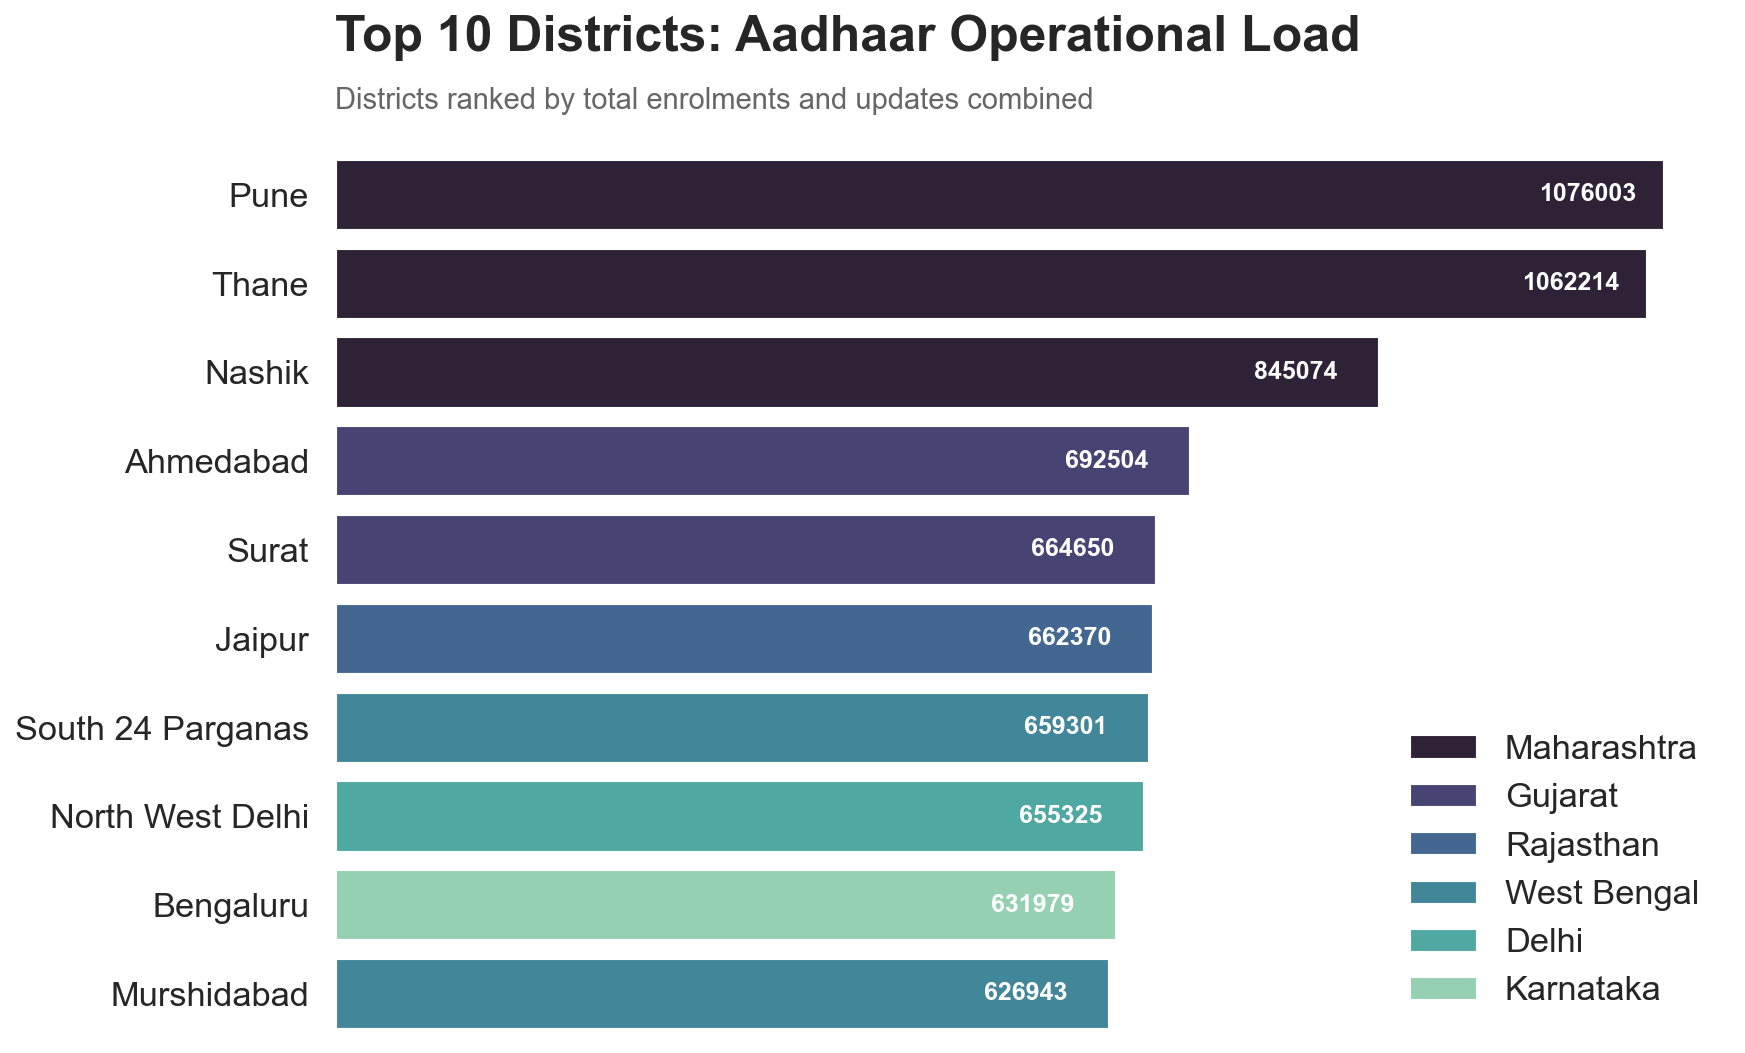

In [ ]:
top10 = hotspots.head(10)

sns.set_context("talk")
sns.set_style("white") # Remove grid for a cleaner look

# plot
ax = sns.barplot(
    data=top10,
    y="district",
    x="total_activity",
    hue="state",
    palette="mako", # 'mako' is a very sleek teal/blue palette
    dodge=False
)

plt.text(x=0, y=1.1, s="Top 10 Districts: Aadhaar Operational Load", 
         fontsize=24, weight='bold', ha='left', va='bottom', transform=ax.transAxes)

plt.text(x=0, y=1.04, s="Districts ranked by total enrolments and updates combined", 
         fontsize=14, color='#666666', ha='left', va='bottom', transform=ax.transAxes)

# --- Data Labels ---
# Added color='white' for better contrast against the dark bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=-60, fontsize=12, color='white', weight='bold')

# Cleanup
plt.xlabel("")
plt.ylabel("") 
plt.xticks([]) # Remove x-axis numbers
sns.despine(left=True, bottom=True) # Remove border

# Legend
plt.legend(loc="lower right", frameon=False)
plt.subplots_adjust(top=0.85)

plt.show()

## Insight: Operational Load Hotspots

### Certain districts exhibit disproportionately high Aadhaar activity when enrolment, demographic activity, and biometric activity are combined.

These hotspots represent regions where:
- Service demand is consistently high
- Infrastructure and staffing pressure is likely concentrated
- Proactive resource planning can reduce citizen friction

This insight is derived purely from aggregated activity patterns and does not rely
on individual-level behavior or assumptions.